## Import Frequently Used Libraries and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

## User-Defined Parameters

Main configuration settings for the confusion method and neural network training.

In [2]:
# --- Data selection ---

# Select the "eta" value. 
# The repository currently includes data for eta = 0.02 and eta = 0.06.
eta = 0.06  

# Path to the data directory.
# Update this path if your data is stored in a different location than the current working directory.
path_to_data = f"data_eta_{eta:.2f}"

# Select the type of data to use: position coordinates or magnetic dipoles.
# Set to True to use magnetic dipole data; set to False to use position data.
use_magnetic_data = False 

# Specify the range of energy bins to include in the analysis
lowest_bin_to_read = 18   # Lowest energy bin to include
highest_bin_to_read = 56  # Highest energy bin to include

# Maximum number of samples to include from each bin
max_samples_per_bin = 2000



# --- Confusion method ---

# Number of independent confusion runs (used to reduce statistical fluctuations)
num_runs = 10

# Fraction of data reserved for testing 
test_size = 0.33



# --- Neural network hyperparameters ---

# Number of hidden layers
num_hidden_layers = 2

# Number of neurons per hidden layer
num_neurons_per_layer=50

# Number of epochs (training iterations)
epochs = 20  

# Learning rate for SGD optimizer
learning_rate = 0.001

## Read Polymer Configurations and Construct the Feature Matrix

In [3]:
# Construct the feature matrix from configuration files.
# When use_magnetic_data is False, the features are position coordinates of monomers.
# When use_magnetic_data is True, the features are normalized magnetic dipole components.

X = [] # Feature matrix
bin_nums = [] # Corresponding bin number for each configuration

mag_moment = np.sqrt(5.0) # The magnitude of magnetic dipole moment

for bin_num in range(lowest_bin_to_read, highest_bin_to_read+1):
    print(f'Now reading bin_num {bin_num}')

    # Find all configuration files associated with the current bin number
    all_files = [file_name for file_name in os.listdir(path_to_data) if file_name.startswith(f'Chain_bin{bin_num:05d}_') and file_name.endswith('.dat') ]

    # Limit the number of samples to max_samples_per_bin
    num_samples_for_this_bin = min(len(all_files), max_samples_per_bin)
    all_files = all_files[:num_samples_for_this_bin]

    for file_name in all_files:
        # Read the current file
        config = pd.read_csv(os.path.join(path_to_data, file_name), header=None, sep=r'\s+')
        config = config.to_numpy()

        if use_magnetic_data:
            # Normalize magnetic dipoles by dividing by the magnitude
            config[:, 3:6] /= mag_moment  
            
            # Append the data for the current configuration into the feature matrix
            X.append(config[:, 3:].flatten())
        else: 
            # Subtract the center of mass from the position coordinates
            config[:, 0:3] -= np.mean(config[:, 0:3], axis=0)
            
            # Append the data for the current configuration into the feature matrix
            X.append(config[:, 0:3].flatten())
        
        bin_nums.append(bin_num)

# Convert lists to NumPy arrays
X = np.array(X)
bin_nums = np.array(bin_nums)

Now reading bin_num 18
Now reading bin_num 19
Now reading bin_num 20
Now reading bin_num 21
Now reading bin_num 22
Now reading bin_num 23
Now reading bin_num 24
Now reading bin_num 25
Now reading bin_num 26
Now reading bin_num 27
Now reading bin_num 28
Now reading bin_num 29
Now reading bin_num 30
Now reading bin_num 31
Now reading bin_num 32
Now reading bin_num 33
Now reading bin_num 34
Now reading bin_num 35
Now reading bin_num 36
Now reading bin_num 37
Now reading bin_num 38
Now reading bin_num 39
Now reading bin_num 40
Now reading bin_num 41
Now reading bin_num 42
Now reading bin_num 43
Now reading bin_num 44
Now reading bin_num 45
Now reading bin_num 46
Now reading bin_num 47
Now reading bin_num 48
Now reading bin_num 49
Now reading bin_num 50
Now reading bin_num 51
Now reading bin_num 52
Now reading bin_num 53
Now reading bin_num 54
Now reading bin_num 55
Now reading bin_num 56


## Function: Build and Train a Feed-Forward Neural Network

Defines and trains a feed-forward neural network using the Keras API. Returns the final accuracy on the training and test sets.

In [4]:
def train_model(X_train, y_train, X_test, y_test, num_hidden_layers=2, num_neurons_per_layer=50, epochs=20, learning_rate=0.001):
    # Define a feed-forward neural network
    model = keras.models.Sequential()
    
    # Add input layer
    model.add(keras.layers.Dense(num_neurons_per_layer, activation='relu', input_shape=(X_train.shape[1],)))

    # Add hidden layers
    for _ in range(num_hidden_layers - 1):
        model.add(keras.layers.Dense(num_neurons_per_layer, activation='relu'))

    # Add output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        verbose=0)
    
    # Return final training and test accuracy
    return history.history['accuracy'][-1], history.history['val_accuracy'][-1]

## Run the Confusion Method Over Trial Transition Points

In [5]:
# Define trial transition points.
# Here, we choose the trial transition points to be the centers of the energy bins.
bin_centers = np.arange(lowest_bin_to_read - 0.5, highest_bin_to_read + 1.5, 1)

# Lists to store accuracy results for each trial transition point
mean_train_accuracy = [] # Mean training accuracy
err_train_accuracy = [] # Standard error of training accuracy
mean_test_accuracy = [] # Mean test accuracy
err_test_accuracy = [] # Standard error of test accuracy

for i, trial_trans_point in enumerate(bin_centers):
    print(f"Now working on trial transition point {i+1} of {len(bin_centers)}")
    
    # Assign labels based on the trial transition point
    y = np.where(bin_nums<trial_trans_point, 0, 1)

    train_accuracy = np.zeros(num_runs) 
    test_accuracy = np.zeros(num_runs)

    for run_num in range(num_runs):
        # Randomly split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        # Build and train a neural network
        train_acc, test_acc = train_model(X_train, y_train, X_test, y_test, num_hidden_layers, num_neurons_per_layer, epochs, learning_rate)
        
        train_accuracy[run_num] = train_acc
        test_accuracy[run_num] = test_acc

    # Compute mean and standard error of training accuracy
    mean_train_accuracy.append(train_accuracy.mean())
    err_train_accuracy.append(train_accuracy.std(ddof=1)/np.sqrt(num_runs))

    # Compute mean and standard error of test accuracy
    mean_test_accuracy.append(test_accuracy.mean())
    err_test_accuracy.append(test_accuracy.std(ddof=1)/np.sqrt(num_runs))

Now working on trial transition point 1 of 40
Now working on trial transition point 2 of 40
Now working on trial transition point 3 of 40
Now working on trial transition point 4 of 40
Now working on trial transition point 5 of 40
Now working on trial transition point 6 of 40
Now working on trial transition point 7 of 40
Now working on trial transition point 8 of 40
Now working on trial transition point 9 of 40
Now working on trial transition point 10 of 40
Now working on trial transition point 11 of 40
Now working on trial transition point 12 of 40
Now working on trial transition point 13 of 40
Now working on trial transition point 14 of 40
Now working on trial transition point 15 of 40
Now working on trial transition point 16 of 40
Now working on trial transition point 17 of 40
Now working on trial transition point 18 of 40
Now working on trial transition point 19 of 40
Now working on trial transition point 20 of 40
Now working on trial transition point 21 of 40
Now working on trial t

## Save Accuracy vs. Trial Transition Energy Data to File

In [6]:
# --- Map bins to energies ---
if eta==0.02:
    trial_transition_energy = (bin_centers * 100) / 21.16 - 1145
elif eta==0.06:
    trial_transition_energy = (bin_centers * 100) / 20.20 - 1190
else:
    raise ValueError(f'Invalid eta value: {eta}. Supported values are 0.02 and 0.06.')


# --- Save results to CSV file ---

# Construct a Pandas DataFrame
results = pd.DataFrame({
    'bin_center': bin_centers,
    'trial_transition_energy': trial_transition_energy,
    'mean_test_accuracy': mean_test_accuracy,
    'err_test_accuracy': err_test_accuracy,
})

data_type = 'magnetic' if use_magnetic_data else 'spatial'
output_file = f'confusion_results_{data_type}_eta_{eta:.2f}_bin_range_{lowest_bin_to_read}_{highest_bin_to_read}.csv'

# Save the DataFrame to disk
results.to_csv(output_file, index=False)

## Plot Results

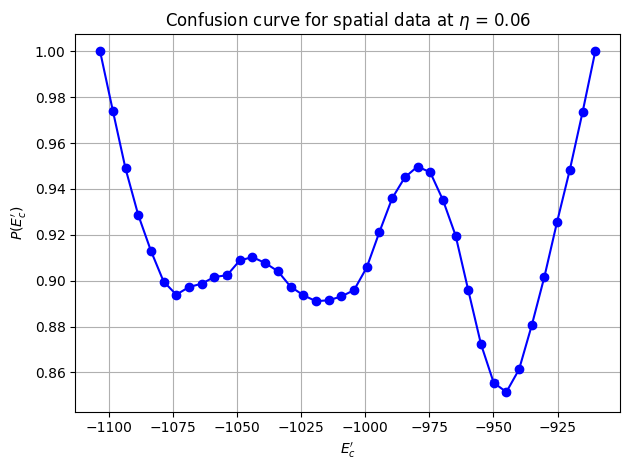

In [7]:
# Plot test accuracy as a function of trial transition energy

plt.errorbar(trial_transition_energy, mean_test_accuracy, yerr=err_test_accuracy, fmt='bo-', capsize=3)
plt.xlabel(r"$E_c^\prime$")
plt.ylabel(r"$P(E_c^\prime)$")
plt.title(f"Confusion curve for {data_type} data at $\eta$ = {eta}")
plt.grid(True)
plt.tight_layout()
plt.show()